In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

In [3]:
# define a function used to get the design matrix
def get_PHI(x):
    N = len(x)
    ones = np.ones(N).reshape(N, 1)
    PHI = np.concatenate((ones,x), axis=1)
    return PHI

# define a function used to get the accuracy
def get_accuracy(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    SS_tot = ((y - y.mean()) ** 2).sum()
    SS_res = ((y - y_pred) ** 2).sum()
    accuracy = 1 - SS_res / SS_tot
    return accuracy
 
# define a function used to get the root mean squared error
def get_rms(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    err = np.sqrt(np.mean((y-y_pred)**2))
    return err

# define a function used to get the prediction
def predict(target_PHI, weights):
    
    prediction = np.dot(target_PHI, weights)
    
    return prediction

In [4]:
# pre-processing
x_train = np.array(train.iloc[:,:-1]).astype(float)
y_train = np.array(train.iloc[:,-1]).astype(float)
x_test = np.array(test.iloc[:,:-1]).astype(float)
y_test = np.array(test.iloc[:,-1]).astype(float)
PHI_train = get_PHI(x_train)
PHI_test = get_PHI(x_test)

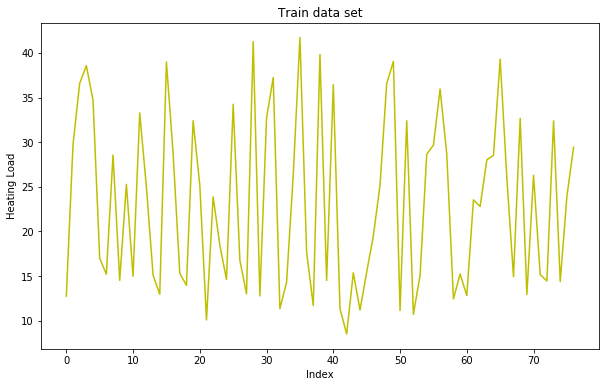

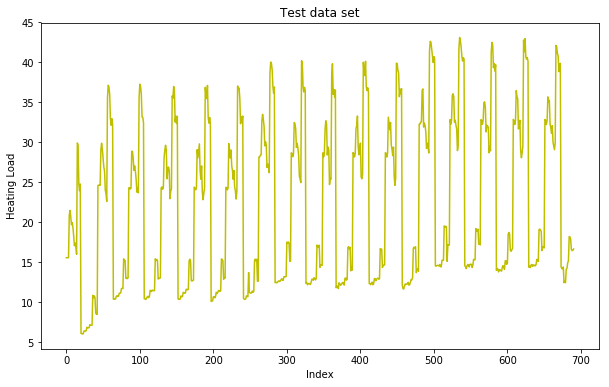

In [5]:
# plot train data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_train)), y_train, c = 'y')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Train data set')
plt.show()

# plot test data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_test)), y_test, c = 'y')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Test data set')
plt.show()

## Bayes Linear Regression

Brute force a grid 200*200 to minimise the neg log marginal likelihood

can do minimization in scipy minimise or tensorflow whatever

In [6]:
def compute_posterior(PHI,y,alph,s2):
    lam = alph * s2
    I = np.eye(PHI.shape[1])
    Mu = np.dot(np.dot(np.linalg.inv(np.dot(PHI.T,PHI)+lam*I),PHI.T),y)
    SIGMA = s2 * np.linalg.inv(np.dot(PHI.T,PHI)+lam*I)
    return (Mu, SIGMA)

def compute_neg_log_marginal_likelihood(PHI,y,alph,s2):
    I = np.eye(y.shape[0])
    Mean = np.zeros(y.shape[0])
    Covariance = s2 * I + (alph**(-1)) * np.dot(PHI,PHI.T)
    lgp = stats.multivariate_normal.logpdf(y.flatten(), mean = Mean, cov = Covariance, allow_singular = True)
    return -lgp

def Bayes_Linear_Regression(train_PHI, train_y):
    i_alph = np.linspace(-10,10,201)
    i_s2 = np.linspace(-10,10,201)
    alph_space = 10**i_alph
    s2_space = 10**i_s2

    best_alph = 0
    best_s2 = 0
    best_n_lgp = np.inf
    for alph,s2 in itertools.product(alph_space, s2_space):
        n_lgp = compute_neg_log_marginal_likelihood(train_PHI, train_y, alph, s2)
        if n_lgp < best_n_lgp:
            best_n_lgp = n_lgp
            best_alph = alph
            best_s2 = s2      
    Mu, _ = compute_posterior(train_PHI, train_y, best_alph, best_s2)
    
    return Mu

In [7]:
# get accuracy and rms
weights1 = Bayes_Linear_Regression(PHI_train, y_train)
y_train_pred1 = predict(PHI_train, weights1)
y_test_pred1 = predict(PHI_test, weights1)

print('Bayes Linear Regression accuracy on train data set is', get_accuracy(y_train, y_train_pred1)*100, '%')
print('Bayes Linear Regression accuracy on test data set is', get_accuracy(y_test, y_test_pred1)*100, '%')

print('Bayes Linear Regression rms on train data set is', get_rms(y_train, y_train_pred1))
print('Bayes Linear Regression rms on test data set is', get_rms(y_test, y_test_pred1))

Bayes Linear Regression accuracy on train data set is 89.62347996882205 %
Bayes Linear Regression accuracy on test data set is 90.38537340348861 %
Bayes Linear Regression rms on train data set is 3.1368033103075135
Bayes Linear Regression rms on test data set is 3.1372782208691063


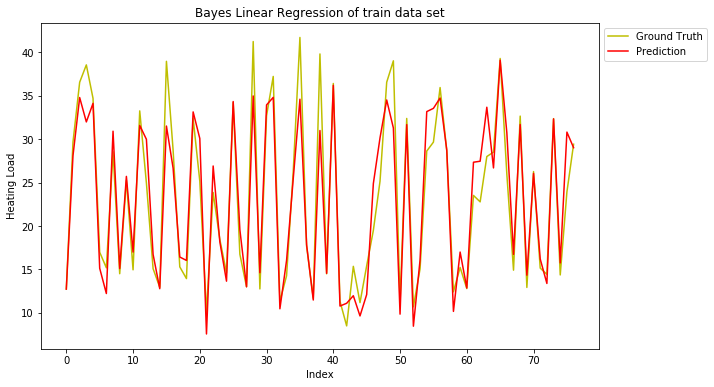

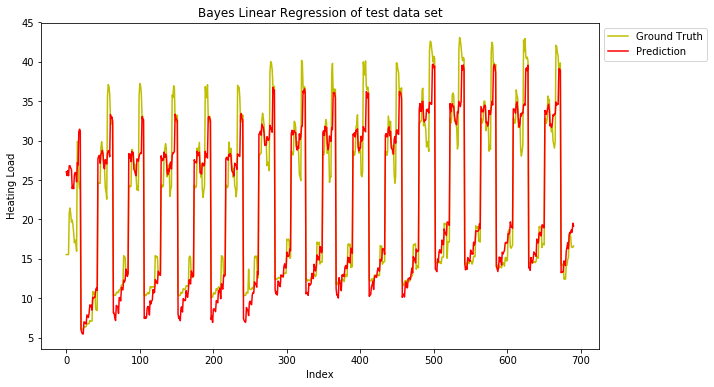

In [8]:
# plot train data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_train)), y_train, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_train)), y_train_pred1, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Bayes Linear Regression of train data set')
plt.show()

# plot test data set
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_test)), y_test, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_test)), y_test_pred1, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Bayes Linear Regression of test data set')
plt.show()

## Bayes Linear Regression using Gibbs sampling

In [9]:
def Gibbs_Bayes_LR(PHI, y, iterations = 1000): 
    if y.ndim == 1:
        y = y.reshape(-1, 1)
        
    n_samples, n_features = PHI.shape
    w_prior = np.zeros(n_features).reshape(-1,1)
    sig_prior = np.sqrt(1/0.0001)*np.eye(n_features)
    
    #starting values
    T0 = 10**(-2)  #prior degrees of freedom for inverse gamma distribution
    D0 = 10**(2) #prior scale parameter
    weights = w_prior
    sigma_sq = 10
    
    for i in range(iterations):
        # sample weights conditional on sigma N(Mu, Var)
        Mu = np.dot(np.linalg.inv(np.linalg.inv(sig_prior) + (1 / sigma_sq) * np.dot(PHI.T, PHI)),
                    (np.dot(np.linalg.inv(sig_prior), w_prior) + (1 / sigma_sq) * np.dot(PHI.T, y)))
        Mu = Mu.reshape(n_features, 1)
        Var = np.linalg.inv(np.linalg.inv(sig_prior)+(1/sigma_sq)*np.dot(PHI.T,PHI))
        weights = np.random.multivariate_normal(np.asarray(Mu.T)[0], Var)
        weights = weights.reshape(n_features,1)
        # sample sigma conditional on weights from IG(T1,D1);
        matrix_0 = np.dot(PHI, weights)
        resids = y-matrix_0
        #compute posterior df and scale matrix
        T1 = T0 + n_samples;
        D1 = D0 + np.dot(resids.T, resids)
        #draw from IG
        z0 = np.random.normal(0, 1, (int(T1), 1))
        z0z0 = np.dot(z0.T, z0)
        sigma_sq = D1 / z0z0
        sigma_sq = sigma_sq[0,0]
        
    return weights.T[0]

In [10]:
# get accuracy and rms
weights2 = Gibbs_Bayes_LR(PHI_train, y_train, iterations = 1000)
y_train_pred2 = predict(PHI_train, weights2)
y_test_pred2 = predict(PHI_test, weights2)

print('Gibbs Bayes LR accuracy on train data set is', get_accuracy(y_train, y_train_pred2)*100, '%')
print('Gibbs Bayes LR accuracy on test data set is', get_accuracy(y_test, y_test_pred2)*100, '%')

print('Gibbs Bayes LR rms on train data set is', get_rms(y_train, y_train_pred2))
print('Gibbs Bayes LR rms on test data set is', get_rms(y_test, y_test_pred2))

Gibbs Bayes LR accuracy on train data set is 89.30259629368264 %
Gibbs Bayes LR accuracy on test data set is 89.66020456870989 %
Gibbs Bayes LR rms on train data set is 3.184935313164677
Gibbs Bayes LR rms on test data set is 3.2534399617147485


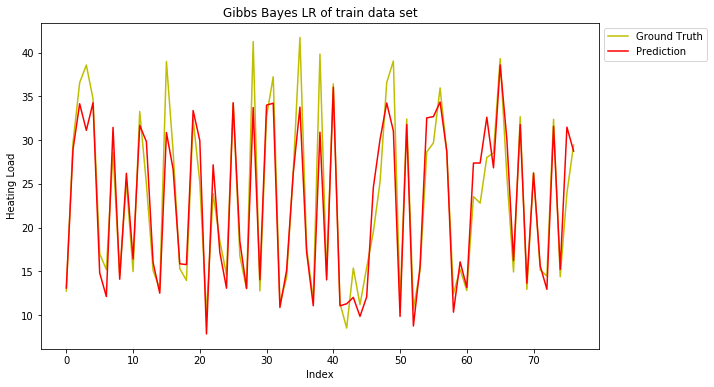

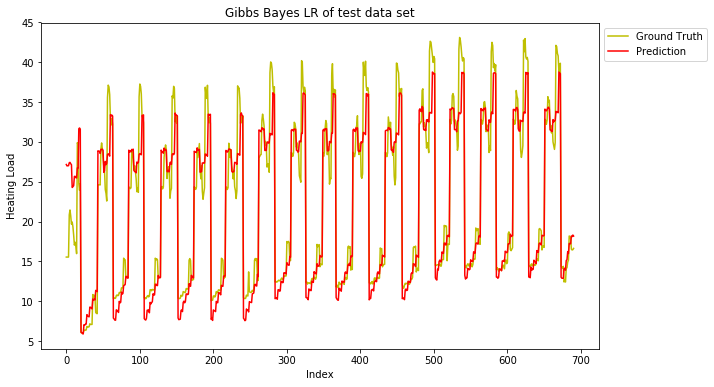

In [11]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_train)), y_train, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_train)), y_train_pred2, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Gibbs Bayes LR of train data set')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(np.arange(len(y_test)), y_test, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_test)), y_test_pred2, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Gibbs Bayes LR of test data set')
plt.show()

## Metropolis Algorithm

Metropolis Algorithm Linear regression not performs well with real data, so we used simulated data instead.

### Generate Data
We synthesise two data sets:
- training set of size $N=30$ with added noise std. dev. $\sigma=0.2$
- test set of size $N=250$ with **no noise**, representing the true function

The "input" $x$ data lies in the range $[0,10]$.

### Generate Basis
We utilise a Gaussian RBF basis function set, where $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. The length scale, or width, $r$ is common across basis functions, but each has its own center $c_m$. These centres are equally spaced and will remain fixed. We will, however, experiment with varying length scales $r$.

### Example Model Fit
For arbitrarily selected values of $\alpha$, $\sigma^2$ and $r$, the posterior mean predictor is computed and graphed for illustrative purposes.

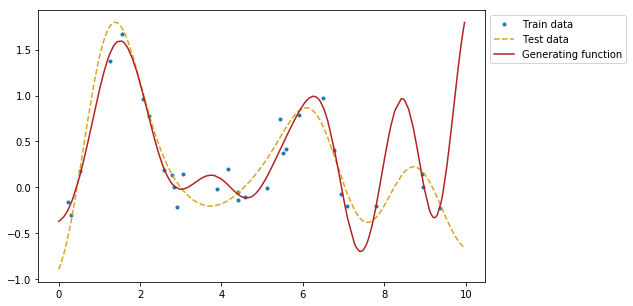

In [12]:
import Data_Generator as setup

# Parameters that determine the generated data
#
sig_gen = 0.2
s2_gen = sig_gen**2
r_gen = 1
x_max = 10
#
N_train = 30
N_test = 250

# Parameters the determine the basis set used for modelling
# - note that the length scale will be varied
#
M = 16# Number of functions, spaced equally
C = np.linspace(0,x_max,M)
Data = setup.DataGenerator(M=9, r=r_gen, noise=sig_gen, randOffset=3)
x_train, y_train = Data.get_data('TRAIN',N_train)
x_test, y_test = Data.get_data('TEST', N_test)

# Demonstrate use of basis
r = 0.75
RBF = setup.RBFGenerator(C, r) # C was fixed earlier
PHI_train = RBF.evaluate(x_train)
PHI_test = RBF.evaluate(x_test)
# Find posterior mean for fixed guesses for alpha and s2
alph = 1e-12
s2 = 0.1**2

w_map,_ = setup.compute_posterior(PHI_train, y_train, alph, s2)
model = np.dot(PHI_test, w_map)

# Show the training data and generating function
plt.figure(figsize = (8,5))
plt.plot(x_train, y_train,'.', label = 'Train data')
plt.plot(x_test, y_test,'--', color='goldenrod', label = 'Test data')
plt.plot(x_test, model,'r-', color='firebrick', label = 'Generating function') 
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.show()

### Get best expectations of r

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | \mathbf{t})$ investigated above, using importance sampling. Assume that $\sigma=0.2$ is known. That is, compute (via a sampling approximation):
$$ 
\langle{}r\rangle = \int r . p(\alpha, r | \mathbf{t})\, d\alpha\, dr
$$
We identify $P^\ast(\alpha, r) = p(\mathbf{t}|\alpha,r)$  - assuming uniform log priors for $\alpha$ and $r$ meaning we can neglect those terms. Use that as the target distribution for your sampler.

The sampler is defined such that it can be passed functions which is, `Expectations = importance(K, pstar, qstar, qrvs, fun)` where:
- `K` is the number of samples desired
- `pstar` is a function object which takes an array argument `X = [alpha, r]` and returns $P^\ast(\alpha, r)$
- `qrvs` is a function object which takes no argument, and generates a single sample of $\log\alpha$ and $\log r$ from $Q(\alpha,r)$
- `qstar` is a function object which takes an array argument `X = [alpha, r]` and returns the p.d.f. $Q(\alpha,r)$
- `fun` is the function of `X` to be weighted in the sampling average (which is simply `r`, see above equation)

For example:

`fun = lambda X: 10**X[1]`

and 

`pstar = lambda X: prob_alph_r_given_t(10**X[0], 10**X[1], x_train, t_train, s2, C)`

Define $Q(\alpha,r)$ with a simple Gaussian over $\log\alpha$ and $\log r$.

The sampler should return an array of $K$ expectations, computed for each sample step, the last element of which will be the final expected $\langle{}r\rangle$. 

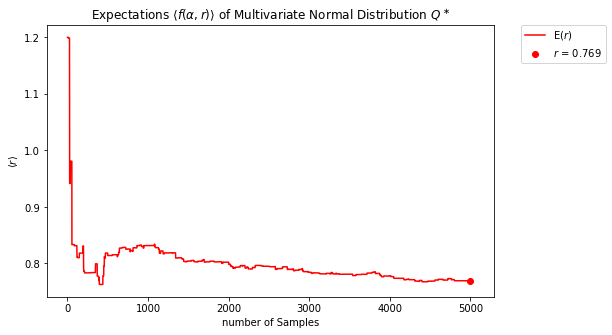

In [13]:
def log_prob_alph_r_given_t(alph, r, x, t, s2, C):
    rbf = setup.RBFGenerator(C, r)
    PHI = rbf.evaluate(x)
    log_p = setup.compute_log_marginal(PHI,t,alph,s2)
    
    return log_p

# get the pdf of p
pstar = lambda X: np.exp(log_prob_alph_r_given_t(10**X[0], 10**X[1], x_train, y_train, s2_gen, C))

# generate log(alpha) and log(r)
def qrvs(model):
    X = model.rvs()
    return X

# get the pdf of q
def qstar(X, model):
    prob = model.pdf(X)
    return prob

# calculate the expectations
def calc_expectations(K, model):
    r_set = []
    weights = []
    r_expectations = []
    
    for i in range(K):
        X = qrvs(model)
        weight = pstar(X)/qstar(X, model)
        r_set.append(fun(X))
        weights.append(weight) 

        r_expectation = (np.array(r_set) * np.array(weights)).sum()/np.array(weights).sum()
        r_expectations.append(r_expectation)
        
    return r_expectations

fun = lambda X: 10 ** X[1]

# assumming log(alpha) and log(r) follow the multivariate normal distribution with assumed Mu and Covariance
Mu = [0,0]
Cov = [[2,0],[0,2]]
rv = stats.multivariate_normal(Mu, Cov)

K = 5000
r_expectations = calc_expectations(K, rv)

plt.figure(figsize=(8,5)) 
plt.plot(np.arange(K), r_expectations, c = 'r', label = 'E($r$)')
plt.scatter(5000, r_expectations[-1], c = 'r', label = '$r$ = %0.3f' % r_expectations[-1])
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.02))
plt.title('Expectations $\\langle{}f(\\alpha,r)\\rangle$ of Multivariate Normal Distribution $Q^\\ast$')
plt.xlabel('number of Samples')
plt.ylabel('$\\langle{}r\\rangle$')
plt.show()

In [14]:
# used best r got above to get a new_PHI_train
best_r = r_expectations[-1]
rbf = setup.RBFGenerator(C, best_r)
new_PHI_train = rbf.evaluate(x_train)

### Metropolis-Hastings Linear Regression

The state space is due to the weights space combined with $\alpha$ and $\sigma^2$

- `X0` is the starting state and `X` is the state
- `K` is the number of samples desired
- `pstar` is a function object which takes an array argument `X = [w_0, ..., w_n, alpha, sigma^2]` and returns $P^\ast(\mathbf{w}, \alpha, \sigma^2)$
- `qrvs` is a function object which takes a single argument `X` (current state), and generates a single combined proposal of $\mathbf{w}$, $\log\alpha$ and $\log \sigma^2$ from $Q$

In [15]:
qrvs = lambda X, COV: stats.multivariate_normal.rvs(size=1, mean=X, cov=COV)

def pstar(w, alph, s2, y, PHI):
    N,M = PHI.shape
    # p1 is P(y|w,σ2)
    p1 = np.prod(stats.multivariate_normal.pdf(y-np.dot(PHI,w).reshape(N,1),mean=None,cov=s2))
    # p2 is P(w|α)
    p2 = np.prod(stats.multivariate_normal.pdf(w,mean=None,cov=alph**(-1)))
    # prob is P∗(w,α,σ2)
    prob = p1 * p2     
                 
    return prob

def Metropolis(PHI, y, K = 10000, scale = 0.001, burn_rate = 0.1):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    N,M = PHI.shape
    X0 = np.zeros(M+2)
    COV = np.eye(M+2,M+2)*scale
    current_state = X0
    accept = []
    reject = []
    for i in range(K):
        next_state = qrvs(current_state, COV)
        p_new = pstar(next_state[:-2], np.exp(next_state[-2]), np.exp(next_state[-1]), y, PHI)
        p_old = pstar(current_state[:-2], np.exp(current_state[-2]), np.exp(current_state[-1]), y, PHI)
        
        p = p_new/p_old
        
        if p >= 1 :
            accept.append(next_state)
            current_state = next_state
        else:
            if np.random.rand() < p:
                accept.append(next_state)
                current_state = next_state
            else:
                reject.append(next_state)
                accept.append(current_state)
                
    reject_rate = len(reject)/K
    print('Rejection rate is', reject_rate*100, '%')
    
    # burn in
    start_point = round(len(accept) * burn_rate)
    weights = np.array(accept)[start_point:].mean(axis = 0)
    
    return weights[:-2]

In [16]:
# get accuracy and rms
weights3 = Metropolis(new_PHI_train, y_train, K = 10000, scale = 0.001, burn_rate = 0.1)
y_train_pred3 = predict(PHI_train, weights3)
y_test_pred3 = predict(PHI_test, weights3)

print('Gibbs Bayes LR accuracy on train data set is', get_accuracy(y_train, y_train_pred3)*100, '%')
print('Gibbs Bayes LR accuracy on test data set is', get_accuracy(y_test, y_test_pred3)*100, '%')

print('Gibbs Bayes LR rms on train data set is', get_rms(y_train, y_train_pred3))
print('Gibbs Bayes LR rms on test data set is', get_rms(y_test, y_test_pred3))

Rejection rate is 44.73 %
Gibbs Bayes LR accuracy on train data set is 93.70407275822198 %
Gibbs Bayes LR accuracy on test data set is 92.79124970683755 %
Gibbs Bayes LR rms on train data set is 0.12383052132524747
Gibbs Bayes LR rms on test data set is 0.17138329928886906


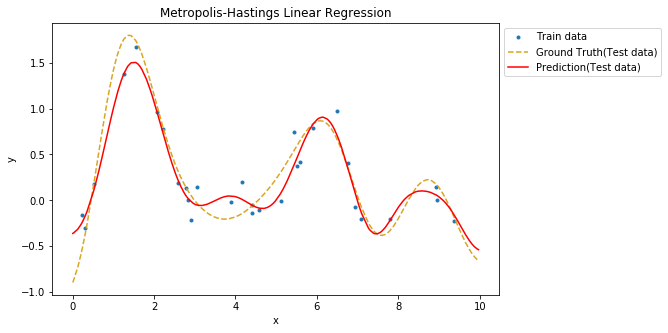

In [17]:
plt.figure(figsize=(8,5))
plt.plot(x_train, y_train, '.', label = 'Train data')
plt.plot(x_test, y_test,'--', color='goldenrod', label = 'Ground Truth(Test data)')
plt.plot(x_test, y_test_pred3, c ='r', label = 'Prediction(Test data)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Metropolis-Hastings Linear Regression')
plt.show()